# Figure 3

Here we'll generate figure 3. 
It contains a scree plot on the percentage of variance explained by each PC, a scatter plot of PC1 and PC2 with the whole sample, including projected faces on top of them, as well as smaller scatter plots for PC1 and PC2 for each of the 3 populations found with fineStructure. Finally, it contains a

In [1]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from matplotlib import cm
from matplotlib import gridspec
from mayavi import mlab
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

Reading databases

In [2]:
#Folders
projpath      = os.path.realpath("../..")
pathlandmarks = os.path.join(projpath, "Results", "Landmarks")
pathfacepca   = os.path.join(projpath, "DataBases", "FacePCA")
pathres       = os.path.join(projpath, "Results")
pathfig       = os.path.join(projpath, "Results", "Figures")

In [34]:
#Databases
os.chdir(pathfacepca)
facets = pd.read_csv("facets.csv", header = None)
os.chdir(pathres)
dat = pd.read_csv("tot_samples.csv")
os.chdir(pathlandmarks)
pc_landmark = np.matrix(pd.read_csv("PC_landmarks.csv", header = None))

Defining functions

In [13]:
###############DEFINE FUNCTIONS#############
def take_screenshot(landmarks, facets, profile = 0, colormap = None ):
    '''
    Take screenshot of rendered 3D face
    Usage
        Input:
            - landmarks: set of 3D landmarks in one single row, in X,Y,Z consecutive fashion
            - facets: the facets that describe the surface from the 3D landmarks
            - profile: whether to take the screenshot from frontal, midway, or profile (0/1/2)
            - colormap: the colormap to be applied to the 3D surface to the scalar argument
        Output:
            - screenshot: np array of 2D picture
    '''
    #Importing required libraries
    import numpy as np
    import pandas as pd
    from mayavi import mlab

    #Setting offscreen rendering, figure, and X,Y,Z objects
    mlab.options.offscreen = True #True or False
    myfig = mlab.figure(bgcolor=(1, 1, 1), size=(1500, 1500)) 
    face  = landmarks.reshape(7160, 3)
    X = np.array(face[:,0]).flatten()
    Y = np.array(face[:,1]).flatten()
    Z = np.array(face[:,2]).flatten()
    
    #Generating the mesh, depending on whether colormap is supplied
    if colormap is None:
        mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='surface', figure = myfig, color=(0.7,0.7,0.7) )
    elif colormap is not None:
        mesh = mlab.triangular_mesh(X,Y,Z, facets-1, representation='surface', figure = myfig, scalars=colormap, colormap='GnBu' )
    
    #Setting mesh properties
    mesh.actor.property.backface_culling = True
    mesh.scene.anti_aliasing_frames = 20
    mesh.scene.camera.compute_view_plane_normal()
    
    #Setting camera
    if profile == 0:
        mesh.scene.camera.position = [-0.005, -0.037, 0.067]
        mesh.scene.camera.view_up  = [-0.05, 1, 0.5]
    elif profile == 1:
        mesh.scene.camera.position = [-0.06, -0.03, 0.04]
        mesh.scene.camera.view_up  = [-0.02, 0.87, 0.48]
    elif profile == 2:
        mesh.scene.camera.position = [-0.082, -0.014, 0.0033]
        mesh.scene.camera.view_up  = [-0.12, 0.81, 0.58]
        
    mesh.scene.camera.clipping_range = [0.03, 0.12]
    #Taking screenshot
    screenshot = mlab.screenshot(myfig, mode='rgba', antialiased=True)
    #Set the white background with an alpha of 0, that is, transparent
    screenshot[ np.all(screenshot == 1, axis=2) ] = 0 
    mlab.close()
    return(screenshot)

def get_euc_dist(landmark1, landmark2):
    '''
    Get the Euclidean distances between to set of 3D landmarks
    Usage
        Input:
            - landmark1 and landmark2: set of 3D landmarks in one single row, in X,Y,Z consecutive fashion, to compute the distances from
        Output:
            - euc_dist: euclidean distance between corresponding set of 3D landmarks
    '''
    #Importing libraries
    import numpy as np
    import pandas as pd
    
    #Setting number of landmarks
    n_landmarks = int(landmark1.shape[1] / 3)
    
    #Reshaping landmarks
    face1 = landmark1.reshape(n_landmarks, 3)
    face2 = landmark2.reshape(n_landmarks, 3)
    #Calculating euclidean distance
    euc_dist = np.array(np.sqrt(np.sum(np.power(face1 - face2, 2), axis=1))).flatten()
    return(euc_dist)

def paste_screenshot(landmarks, facets, ax = ax, pos = (0,0)):
    face  = take_screenshot(landmarks, facets)
    image = OffsetImage(face, zoom=0.05)
    ab = AnnotationBbox(image, pos, xycoords='data', frameon=False)
    ax.add_artist(ab)
    
def scatter_gm(x, y, group, nrow = 1, ncol = 1, index = 1, ticks = 1, xlim = [-0.1, 0.1], ylim = [-0.1, 0.1], means = 0):
    '''
    Generate geometric morphometrics like scatter plot, with axes going through the origin using different colors for groups.
    This function generates an ax object, make sure to have your figure (fig) object already called
    Usage
        Input:
            - x: values to be plotted in the x coordinates
            - y: values to be plotted in the y coordinates
            - group: grouping variable to be maped on the scatter plot
            - nrow: number of rows for subplot
            - ncol: number of columns for subplot
            - index: index to be used by subplot
            - ticks: whether to maintain the default ticks (0), or use one from -0.1 to 0.1 (1)
            - xlim: the limits of x axis
            - ylim: the limits of y axis
            - means: whether mean values of the group variable are to be highlighted (0/1)
        Output:
            - ax: ax matplotlib object
    '''
    #Importing required libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    ax    = fig.add_subplot(nrow, ncol, index)
    color = group.map(color_map)
    if means == 0:
        al = 0.5
    elif means == 1:
        al = 0.2
        mean_male = [x[group=="Male"].mean(), y[group=="Male"].mean()]
        mean_female = [x[group=="Female"].mean(), y[group=="Female"].mean()]

    ax.scatter(x, y, alpha = al, c=color )
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim) 
    
    if means == 1:
        ax.scatter(mean_female[0], mean_female[1], c = color_map['Female'], s=100, edgecolors='black' )
        ax.scatter(mean_male[0], mean_male[1], c = color_map['Male'], s=100, edgecolors='black' )
    
    if ticks == 1:
        plt.xticks([-0.1, -0.05, 0.05, 0.1])
        plt.yticks([-0.1, -0.05, 0.05, 0.1])
    elif ticks == 0:
        plt.xticks([])
        plt.yticks([])
        
    return(ax)


Plot figure

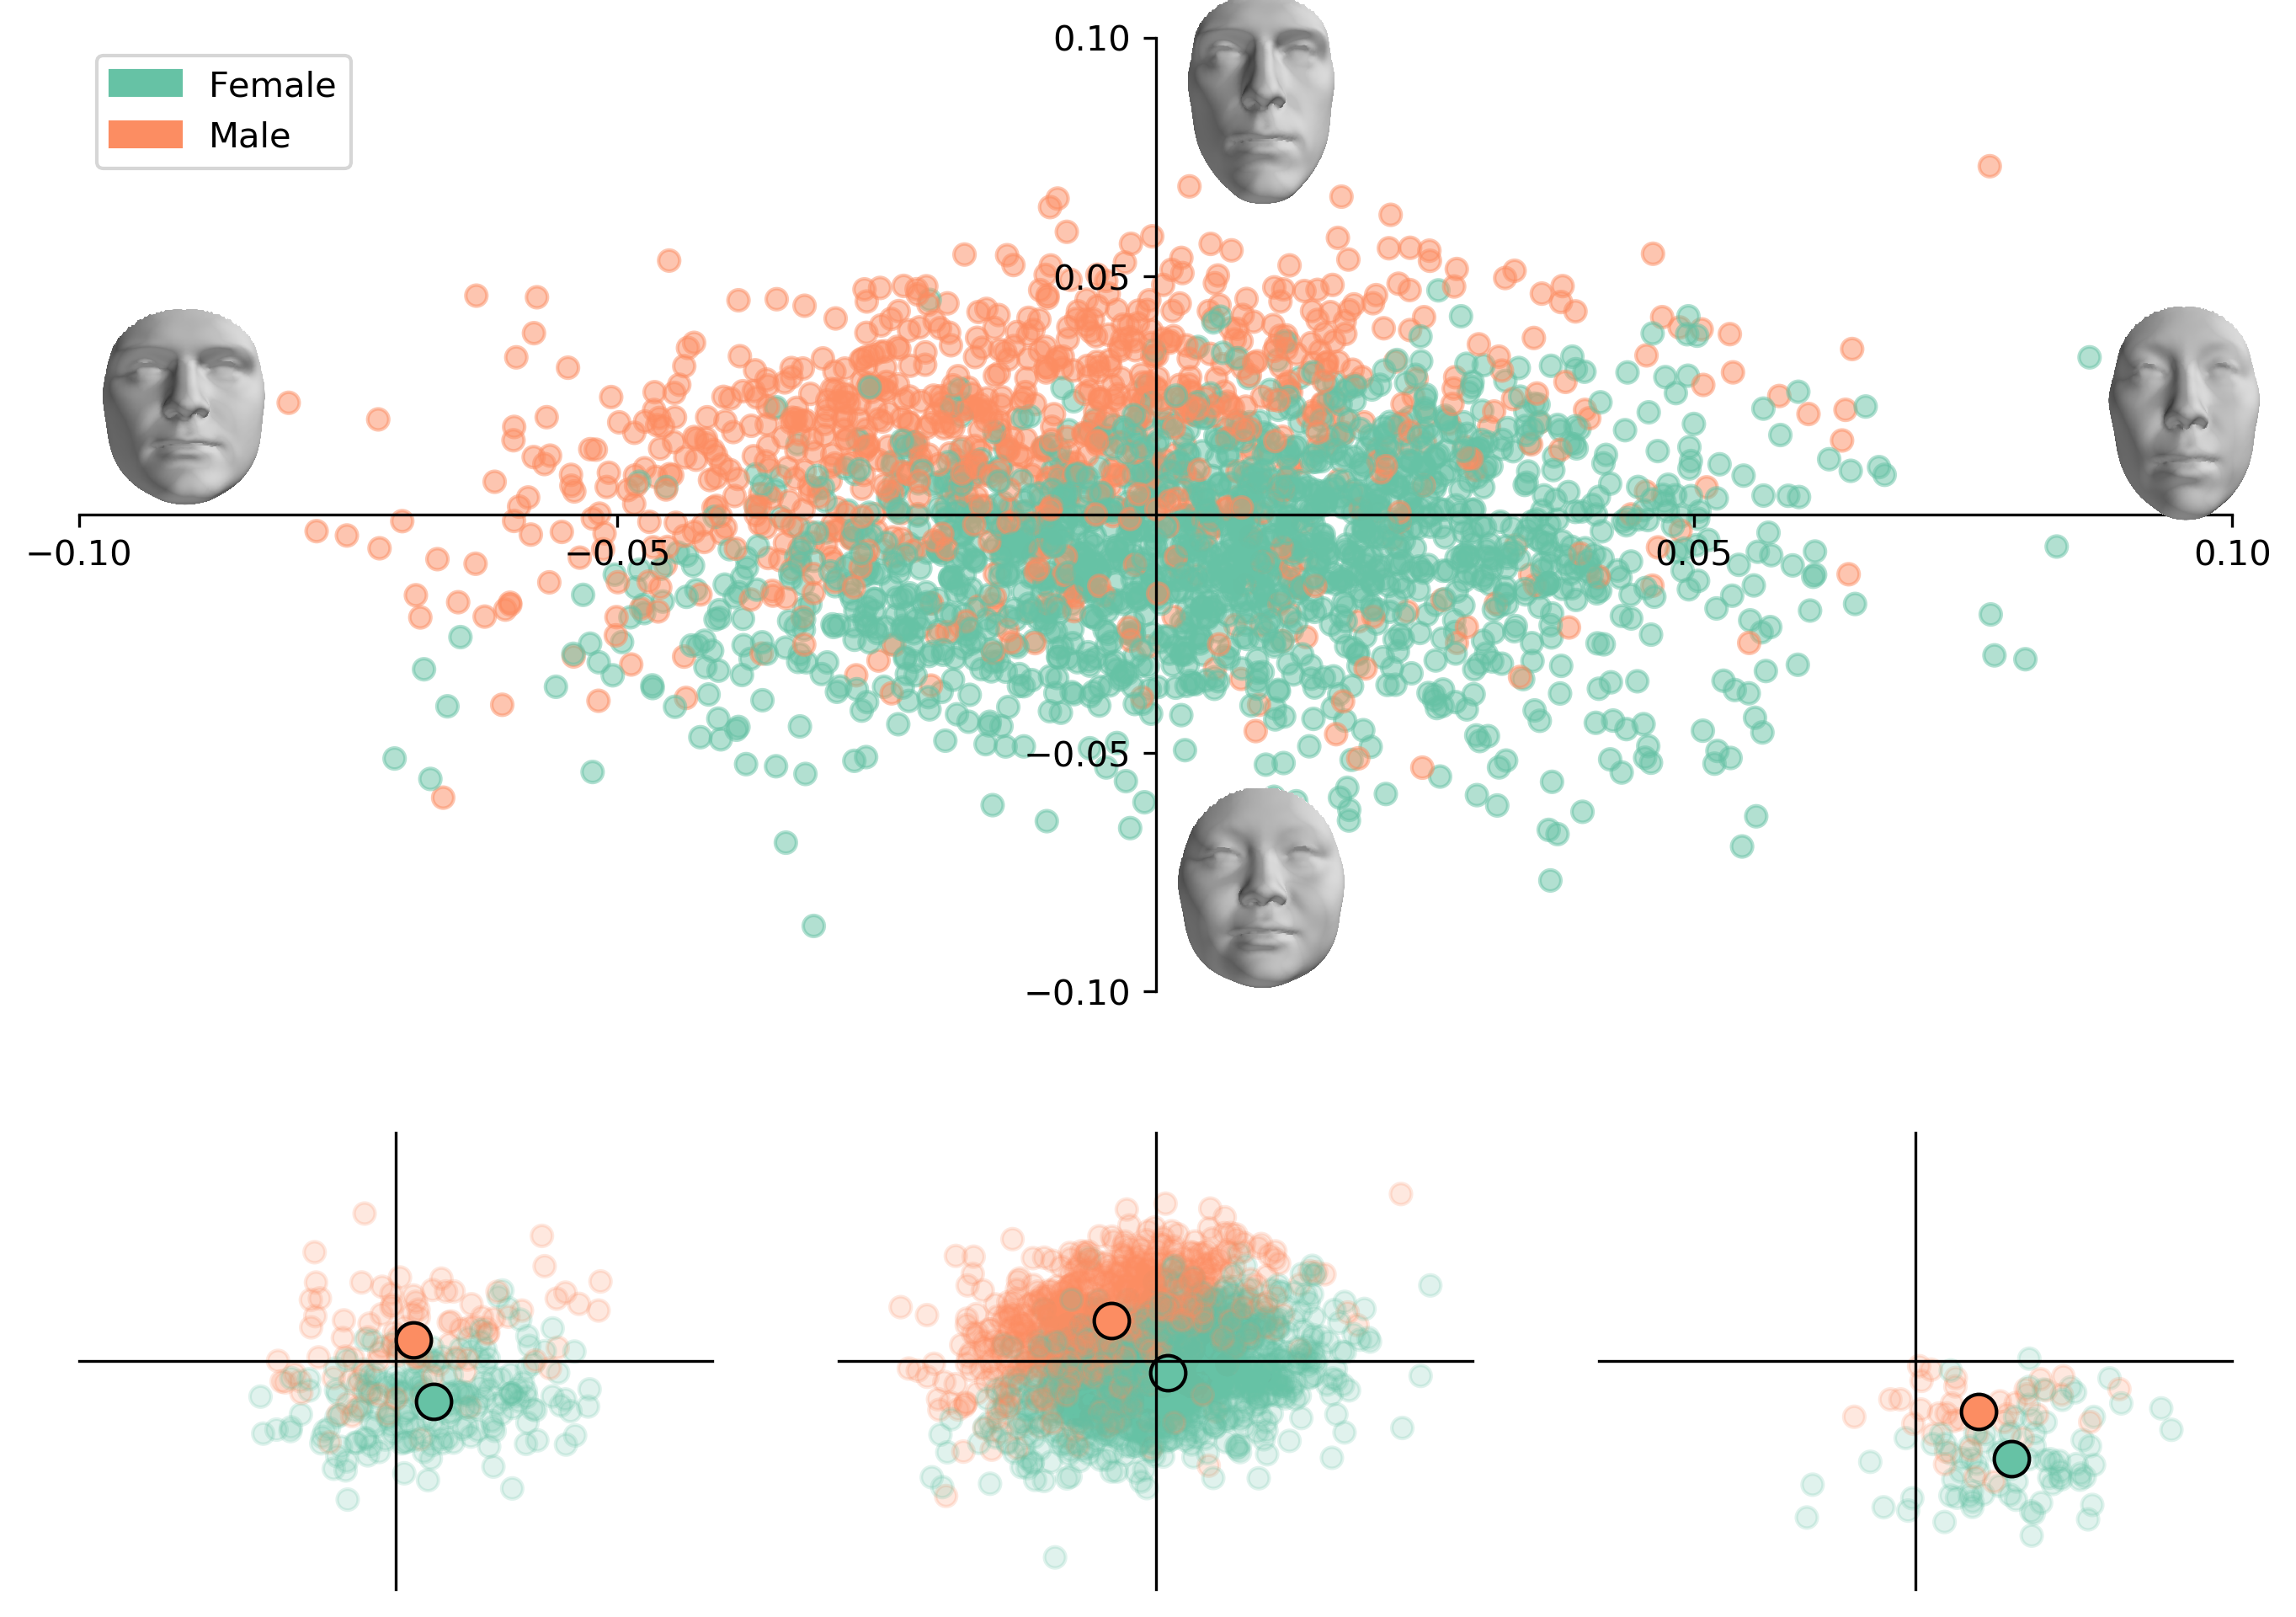

In [47]:
ngroups = dat['cluster_final'].max()

color_labels = dat['Sex'].unique()
rgb_values   = sns.color_palette('Set2', 2)
color_map    = dict(zip(color_labels, rgb_values))

fig = plt.figure(figsize=(11, 11), dpi=300)
ax  = scatter_gm(dat['PC1'], dat['PC2'], dat['Sex'], 2, 1, 1)

paste_screenshot(pc_landmark[0,:], facets, (0.0957, 0.02) )
paste_screenshot(pc_landmark[1,:], facets, (-0.09, 0.02) )
paste_screenshot(pc_landmark[2,:], facets, (0.01, 0.085) )
paste_screenshot(pc_landmark[3,:], facets, (0.01, -0.08) )

#Setting the legend
female_patch = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map["Female"], label='Female')
male_patch   = mpatches.Circle( (0.5, 0.5), radius = 0.25, color=color_map["Male"], label='Male')

plt.legend(handles=[female_patch, male_patch])

#Ploting small plots
for i in range(1,ngroups+1):
    newPC1 = dat[dat['cluster_final'] == i]['PC1'].reset_index(drop=True)
    newPC2 = dat[dat['cluster_final'] == i]['PC2'].reset_index(drop=True)
    newSex = dat[dat['cluster_final'] == i]['Sex'].reset_index(drop=True)
    index  = i + 6
    scatter_gm(newPC1, newPC2, newSex, 4, 3, index, ticks=0, means=1) 

os.chdir(pathfig)
plt.savefig("Figure3.png")
plt.show()